# Bayesian Statistical Modeling: Quantitative Asset Pricing Through a Bayesian Approach

#### Eason Cai

**Date:** 2025-03-02

## 1. Introduction

In modern finance, the distinction between **trading** and **investing** is critical. Both involve buying and selling assets with the intention of generating returns; however, the underlying philosophies differ:

- **Trading:** Focuses on short-term buy and sell with techniques in rigorous quantitative models and rapid execution. Systematic funds, like those pioneered by Jim Simons (the godfather of quantitative finance), exemplify this approach.
- **Investing:** Focuses on long-term buy and sell, drawing on macroeconomic themes, qualitative assessments, and fundamental analyses, as seen with firms like Bridgewater Associates implementing majority proprietary strategies.

### Bayesian Perspective

A Bayesian framework allows us to combine **prior** knowledge (long-term, qualitative insights) with **likelihood** information (short-term, quantitative signals) to form a **posterior** distribution. From this empircal quantitative finance research report, the posterior we find can guide our trading decisions based on asset's true value for future returns.

### Hypothesis

**Will asset price prediction and risk assessment be enhanced if a Bayesian statistical model incorporates technical trading signals in addition to macroeconomic indicators?**

## 2. Conceptual Approach

1. **Prior (Qualitative Inputs)**
   - Macroeconomic indicators such as GDP growth, inflation rates.
   - Market sentiment from financial news, social media, and analyst reports.
   - Historical context regarding economic cycles and monetary policy.

2. **Likelihood (Quantitative Signals)**
   - Statistical or machine learning models such as time-series analysis, factor models.
   - High-frequency/daily price data capturing short-term market fluctuations.
   - Feature engineering using moving averages, volatility measures, trading volumes.

3. **Posterior (Trading Execution)**
   - The posterior distribution combines the qualitative and quantitative insights to provide a probability distribution for future returns.
   - Trades are executed only when the posterior probability of a favorable outcome is high.
   - Incorporate risk management protocols in place such as stop-loss levels, position sizing.

By fusing investing (long-term qualitative signals) with trading (short-term quantitative signals), this approach aims to deliver robust, dynamic trading strategies.

## 3. Data Set from Alpha Vantage APIs

We will use the Alpha Vantage API to obtain market data since Alpha Vantage is easy assessible, free and most importantly it has eight different categories: 

1) Core Time Series Stock Data APIs
2) US Options Data APIs
3) Alpha Intelligence™
4) Fundamental Data
5) Physical and Digital/Crypto Currencies
6) Commodities
7) Economic Indicators
8) Technical Indicators

Below, we use Python’s `requests` library to fetch historical daily adjusted data for **SPY** (a proxy for the S&P 500). 

The SPDR S&P 500 ETF Trust is an exchange-traded fund which trades on the NYSE Arca under the symbol SPY. The ETF is designed to track the S&P 500 index by holding a portfolio comprising all 500 companies on the index. It is a part of the SPDR family of ETFs and is managed by State Street Global Advisors. We choose **SPY** because it is suitable for any investors who want to include U.S. equities in their portfolio while taking only a moderate level of risk.

If you would like to reproduce all the following code, please enter your own free API key from [Alpha Vantage](https://www.alphavantage.co/support/#api-key) in the `url` variable below.

In [1]:
import requests
import json
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from datetime import datetime
from private import API_KEY # Store API Key in a separate file for privacy

# Make sure set up your free Alpha Vantage API key to reproduce all code
symbol = "SPY"

# Construct the API URL for monthly adjusted time series data (free endpoint)
url = (
    f"https://www.alphavantage.co/query?function=TIME_SERIES_MONTHLY_ADJUSTED&symbol={symbol}"
    f"&apikey={API_KEY}"
)
response = requests.get(url)

# Parse the JSON response
data_raw = response.json()

# Convert the dictionary to a DataFrame
ts_data = data_raw["Monthly Adjusted Time Series"]
df = pd.DataFrame.from_dict(ts_data, orient='index')
df.index = pd.to_datetime(df.index)

# Rename columns for clarity
df = df.rename(columns={
    "1. open": "open",
    "2. high": "high",
    "3. low": "low",
    "4. close": "close",
    "5. adjusted close": "adjusted_close",
    "6. volume": "volume",
    "7. dividend amount": "dividend_amount"
})

# Ensure the data is sorted by date increasing order for plotting
df = df.sort_index()
cols_name = ["open", "high", "low", "close", "adjusted_close", "volume", "dividend_amount"]
for i in cols_name:
    df[i] = pd.to_numeric(df[i])

df.head()

,open,high,low,close,adjusted_close,volume,dividend_amount
1999-12-31,139.3125,147.5625,139.0000,146.8750,93.5326,121529300,0.3476
2000-01-31,148.2500,148.2500,135.0000,139.5625,88.8758,156770800,0.0000
2000-02-29,139.7500,144.5625,132.7187,137.4375,87.5226,186938300,0.0000
2000-03-31,137.6250,155.7500,135.0312,150.3750,96.0031,247594900,0.3708
2000-04-28,150.1250,153.1093,133.5000,145.0937,92.6314,229246200,0.0000


## 4. Visualize the SPY Data

We now plot the **adjusted close price** of SPY and mark two significant events:

- **2008 Housing Market Crash**
- **2022 COVID Market Impact**

The following code uses `matplotlib` to generate the plot. Let's see how the market behaves over approximately 20 years.

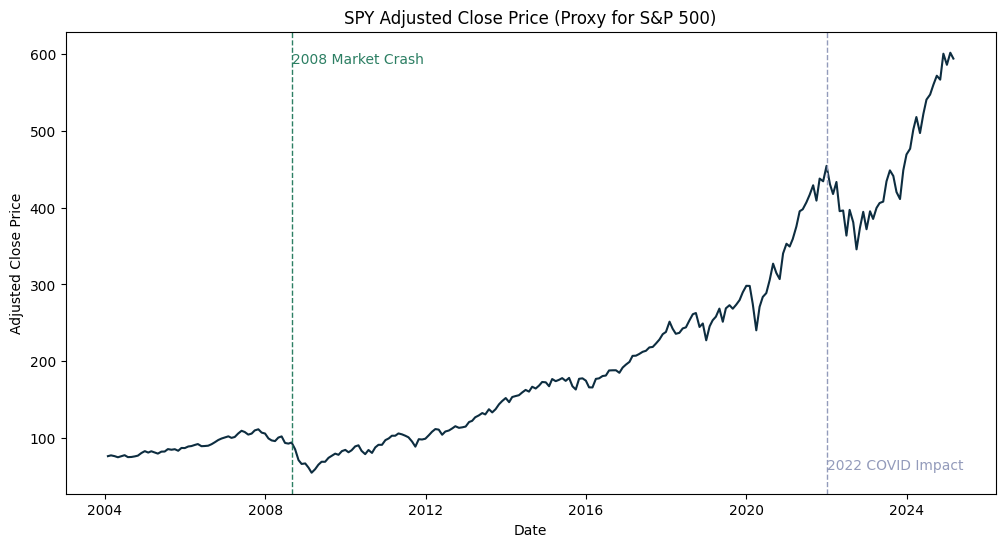

In [2]:
df = df.loc[df.index >= '2004-01-01']

plt.figure(figsize=(12,6))
plt.plot(df.index, df['adjusted_close'], color='#0D2D40')
plt.title('SPY Adjusted Close Price (Proxy for S&P 500)')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')

# Mark the 2008 market crash
plt.axvline(x=pd.to_datetime('2008-09-01'), color='#2C7F63', linestyle='dashed', linewidth=1)
plt.text(pd.to_datetime('2008-09-01'), df['adjusted_close'].max(), '2008 Market Crash', color='#2C7F63', verticalalignment='top')

# Mark the 2022 covid market impact
plt.axvline(x=pd.to_datetime('2022-01-01'), color='#939BBB', linestyle='dashed', linewidth=1)
plt.text(pd.to_datetime('2022-01-01'), df['adjusted_close'].min(), '2022 COVID Impact', color='#939BBB', verticalalignment='bottom')

plt.show()

## 5. Preliminary Result using Single Stock Scenario (APPLE)

### 5.1 Prior Function (Qualitative Inputs)
- Assumption: $\mathcal{N}$ ormal distribution.
- Macro data: Retrieve real GDP data from Alpha Vantage and computes annual growth rates.
- Sentiment scores: List of overall sentiment scores based on Apple news extracted from the Alpha Vantage API.

In [3]:
def get_gdp(api, interval='annual'):
    """
    Retrieve real GDP data from Alpha Vantage and computes (annual/quaterly) growth rates.
    Input: Alpha Vantage API key and choose interval to be either by annual or quater.
    Output: List of annual growth rates (as decimals).
    """
    gdp_url = (
        f"https://www.alphavantage.co/query?function=REAL_GDP&interval={interval}"
        f"&apikey={api}"
    )
    gdp_response = requests.get(gdp_url)
    macro_data = gdp_response.json()
    
    gdp_data = macro_data["data"]
    for entry in gdp_data:
        entry["date_obj"] = datetime.strptime(entry["date"], "%Y-%m-%d")
        entry["value_float"] = float(entry["value"])
    
    # Sort ascending by date
    sorted_data = sorted(gdp_data, key=lambda x: x["date_obj"])
    
    # Compute annual growth rates: (current - previous)/previous
    growth_rates = []
    for i in range(1, len(sorted_data)):
        prev = sorted_data[i-1]["value_float"]
        curr = sorted_data[i]["value_float"]
        # Avoid division by zero, though it shouldn't happen here.
        if prev != 0:
            growth_rate = (curr - prev) / prev
            growth_rates.append(growth_rate)
    return growth_rates

def get_news(api, ticker='AAPL'):
    """
    Retrieve news sentiment data from the Alpha Vantage API for a given ticker.
    Input: Alpha Vantage API key and stock ticker for news sentiment.
    Output: List of overall sentiment scores extracted from the API response.
    """
    alpha_intel_url = (
        f"https://www.alphavantage.co/query?function=NEWS_SENTIMENT&tickers={ticker}"
        f"&apikey={api}"
    )
    news_response = requests.get(alpha_intel_url)
    news_data = news_response.json()
    
    sentiments = []
    for item in news_data["feed"]:
        if "overall_sentiment_score" in item:
            try:
                score = float(item["overall_sentiment_score"])
                sentiments.append(score)
            except ValueError:
                continue  # Skip non-numeric values
    return sentiments

def prior_function(macro_data, news_sentiment, prior_sd):
    """
    Combines macroeconomic growth rates and news sentiment into a prior distribution.
    Input:
      - macro_data (list of float): List of computed macroeconomic growth rates.
      - news_sentiment (list of float): List of news sentiment scores.
      - prior_sd (float): The standard deviation for the prior distribution.
    Output:
      - A dictionary representing a normal distribution with calculated mean and specified standard deviation.
    """
    macro_score = np.mean(macro_data)
    sentiment_score = np.mean(news_sentiment)

    # Combine using a weighted sum: 70% macro information and 30% news sentiment information
    prior_mean = 0.7 * macro_score + 0.3 * sentiment_score
    return {"Distribution": "Normal", "Mean": prior_mean, "Standard Deviation": prior_sd}

macro_info = get_gdp(API_KEY)
news_info = get_news(API_KEY)

# Construct the prior distribution using the computed macro data and news sentiment data
prior_dist = prior_function(macro_info, news_info, prior_sd=0.1)
print("Prior Distribution:", prior_dist)

Prior Distribution: {'Distribution': 'Normal', 'Mean': 0.07451308020133093, 'Standard Deviation': 0.1}


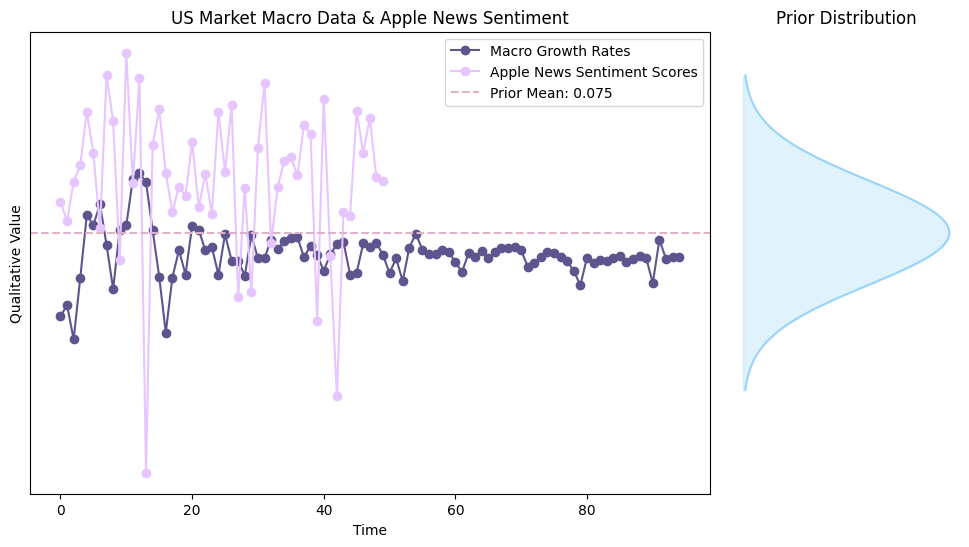

In [4]:
fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1], wspace=0.05)

# Left plot: time series data (macro & news)
ax1 = fig.add_subplot(gs[0])
ax1.plot(macro_info, label='Macro Growth Rates', marker='o', linestyle='-', color='#5e548e')
ax1.plot(news_info, label='Apple News Sentiment Scores', marker='o', linestyle='-', color='#e7c6ff')
prior_mean = prior_dist['Mean']
ax1.axhline(y=prior_mean, color='#e0b1cb', linestyle='--', label=f'Prior Mean: {prior_mean:.3f}')
ax1.set_xlabel('Time')
ax1.set_ylabel('Qualitative Value')
ax1.set_title("US Market Macro Data & Apple News Sentiment")
ax1.legend(loc='best')

# Right plot: prior density function, sharing y-axis with left
ax2 = fig.add_subplot(gs[1], sharey=ax1)
prior_sd = prior_dist['Standard Deviation']
# Generate a range around the prior mean
x_vals = np.linspace(prior_mean - 3*prior_sd, prior_mean + 3*prior_sd, 100)
pdf_vals = norm.pdf(x_vals, loc=prior_mean, scale=prior_sd)
# Plot the density horizontally: density on x-axis, value on y-axis
ax2.plot(pdf_vals, x_vals, color='#9AD5F8', linestyle='-')
ax2.fill_betweenx(x_vals, pdf_vals, color='#9AD5F8', alpha=0.3)
ax2.set_title("Prior Distribution")
ax2.set_yticks([])
ax2.set_xticks([])
# Optionally remove the left spine of the right plot for a cleaner merge
for spine in ax2.spines.values():
    spine.set_visible(False)

plt.show()

### 5.2 Likelihood Function (Quantitative Signals)
We will use the relative strength index (RSI) which is a momentum indicator and one of the most commonly used technical indicators for trading. It measures the speed and strength of the recent price movements to evaluate if the asset could be overvalued or undervalued, and when it could be due for a reversal. The index is an oscillator that ranges from 0 to 100, with a reading under 30 signaling oversold conditions, whereas a reading over 70 signals overbought conditions.

- The RSI provides traders with information about price momentum and is typically plotted below the underlying asset price graph.
- The indicator oscillates between 0 to 100
- A reading >70 signals overbought, whereas <30 signals oversold
- The RSI crossing above the overbought line is typically viewed as a sell signal, whereas a crossing below the oversold line is viewed as a buy signal
- The indicator works best in trading ranges

In [5]:
def get_rsi(api_key, symbol='AAPL', interval='weekly', time_period=10, series_type='open'):
    """
    Retrieve RSI data from the Alpha Vantage API.
    Input: Alpha Vantage API key, ticker symbol, data interval, period for the RSI calculation and price series type.
    Output: A sorted list of tuples (date, RSI_value) where date is a datetime object.
    """
    rsi_url = (
        f"https://www.alphavantage.co/query?function=RSI&symbol={symbol}&interval={interval}"
        f"&time_period={time_period}&series_type={series_type}&apikey={api_key}"
    )
    rsi_response = requests.get(rsi_url)
    rsi = rsi_response.json()
    
    rsi_series = rsi.get("Technical Analysis: RSI", {})
    rsi_list = []
    for date_str, value_dict in rsi_series.items():
        try:
            dt = datetime.strptime(date_str, "%Y-%m-%d")
            rsi_val = float(value_dict["RSI"])
            rsi_list.append((dt, rsi_val))
        except Exception:
            continue
    # Sort ascending by date
    rsi_list = sorted(rsi_list, key=lambda x: x[0])
    return rsi_list

def likelihood_function(price_data, rsi_data, inflate_sd, adjustment_coefficient):
    """
    Calculate simple returns from price data and adjust the likelihood distribution
    using RSI information.
    Input:
      - price_data: array-like, the asset price data.
      - rsi_data: list of RSI values (for a matching period).
      - inflate_sd: factor to adjust the standard deviation.
      - adjustment_coefficient: scaling factor for adjusting the mean based on RSI.
    Output:
      - A dictionary representing a normal distribution with calculated mean and specified standard deviation.
    """
    
    # Find the simple return: (P_t+1 - P_t) / P_t
    price_data = np.array(price_data)
    simple_returns = (price_data[1:] - price_data[:-1]) / price_data[:-1]
    base_mu = np.mean(simple_returns)
    base_sigma = np.std(simple_returns) * inflate_sd
    
    # Normalize the RSI values since RSI oscillate between 0 and 100
    normalized_RSI = (np.array(rsi_data) - 50) / 50.0
    rsi_adjustment = np.mean(normalized_RSI)
    
    # Adjust the base mean based on RSI: 
    # Overbought (RSI>70) -- reduces expected return
    # Oversold (RSI<30)   -- increases expected return
    adjusted_mu = base_mu - (rsi_adjustment * adjustment_coefficient)
    adjusted_sigma = base_sigma * (1 + abs(rsi_adjustment) * 0.5)
    
    return {"Distribution": "Normal", "Mean": adjusted_mu, "Standard Deviation": adjusted_sigma}

aapl_ticker = "AAPL"
aapl_url = (
    f"https://www.alphavantage.co/query?function=TIME_SERIES_MONTHLY_ADJUSTED&symbol={aapl_ticker}"
    f"&apikey={API_KEY}"
)
aapl_response = requests.get(aapl_url)
aapl = aapl_response.json()["Monthly Adjusted Time Series"]
aapl_df = pd.DataFrame.from_dict(aapl, orient='index').rename(columns={
    "1. open": "open",
    "2. high": "high",
    "3. low": "low",
    "4. close": "close",
    "5. adjusted close": "adjusted_close",
    "6. volume": "volume",
    "7. dividend amount": "dividend_amount"
})
aapl_df = aapl_df.sort_index()
cols_name = ["open", "high", "low", "close", "adjusted_close", "volume", "dividend_amount"]
for i in cols_name:
    aapl_df[i] = pd.to_numeric(aapl_df[i])
    
aapl_adj_closed = aapl_df['adjusted_close'].tail(100).values


# Fetch RSI data for ticker AAPL.
rsi_data_list = get_rsi(API_KEY, symbol='AAPL', interval='weekly', time_period=10, series_type='open')
# Use the last 50 RSI values if available; otherwise, fallback to 50 neutral values.
if len(rsi_data_list) >= 50:
    rsi_dates, rsi_values = zip(*rsi_data_list[-50:])
else:
    rsi_dates = [datetime.now()] * 50
    rsi_values = [50.0] * 50  # Neutral fallback

# Construct the likelihood distribution using simple returns and RSI values.
likelihood_dist = likelihood_function(aapl_adj_closed, rsi_values, inflate_sd=1.2, adjustment_coefficient=0.2)
print("Likelihood Distribution:", likelihood_dist)


Likelihood Distribution: {'Distribution': 'Normal', 'Mean': -0.004854783815224372, 'Standard Deviation': 0.10459735333953894}


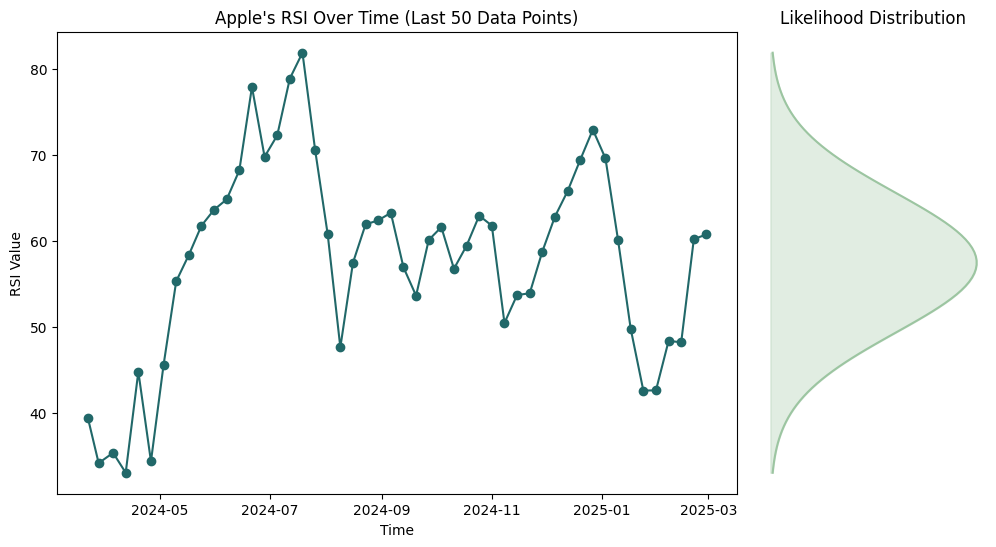

In [6]:
fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1], wspace=0.05)

# Left Plot: RSI over Time
ax1 = fig.add_subplot(gs[0])
ax1.plot(rsi_dates, rsi_values, marker='o', linestyle='-', color='#216869')
ax1.set_title("Apple's RSI Over Time (Last 50 Data Points)")
ax1.set_xlabel("Time")
ax1.set_ylabel("RSI Value")

# Right Plot: Likelihood Density Plot
mu = likelihood_dist["Mean"]
sigma = likelihood_dist["Standard Deviation"]

# Generate x-values spanning about 3 sigma around the mean.
x_values = np.linspace(mu - 3 * sigma, mu + 3 * sigma, 100)
pdf_values = norm.pdf(x_values, mu, sigma)

# Plot the likelihood density horizontally: density on x-axis, return values on y-axis.
ax2 = fig.add_subplot(gs[1])
ax2.plot(pdf_values, x_values, color='#9cc5a1')
ax2.fill_betweenx(x_values, pdf_values, alpha=0.3, color='#9cc5a1')
ax2.set_title("Likelihood Distribution")
ax2.set_yticks([])
ax2.set_xticks([])
# Optionally remove the left spine of the right plot for a cleaner merge
for spine in ax2.spines.values():
    spine.set_visible(False)

plt.show()

### 5.3 Posterior Function (Trading Execution)
- This function calculates daily returns from price data and produces a likelihood distribution based on the returns.

Posterior Distribution: {'Distribution': 'Normal', 'Mean': 0.036611663794209104, 'Standard Deviation': 0.07228131906430797}


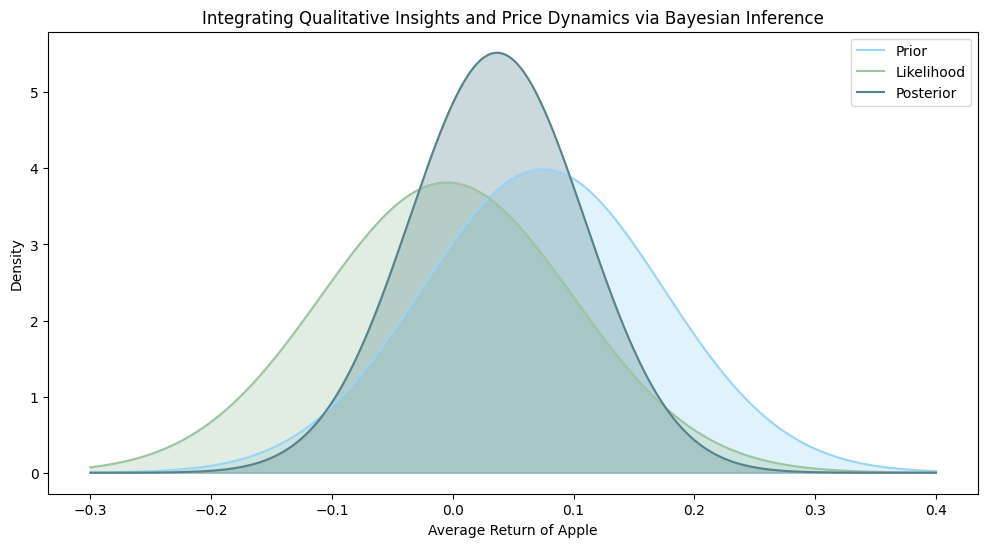

In [7]:
def posterior_function(prior, likelihood):
    """
    Combine a normal prior and a normal likelihood (conjugate case)
    to form a normal posterior.
    """
    prior_mean = prior['Mean']
    prior_sd = prior['Standard Deviation']
    likelihood_mean = likelihood['Mean']
    likelihood_sd = likelihood['Standard Deviation']
    
    posterior_mean = (likelihood_sd**2 * prior_mean + prior_sd**2 * likelihood_mean) / (prior_sd**2 + likelihood_sd**2)
    posterior_sd = np.sqrt((prior_sd**2 * likelihood_sd**2) / (prior_sd**2 + likelihood_sd**2))
    
    return {"Distribution": "Normal", "Mean": posterior_mean, "Standard Deviation": posterior_sd}

# Compute the posterior.
posterior_dist = posterior_function(prior_dist, likelihood_dist)
print("Posterior Distribution:", posterior_dist)

# Create an x-axis grid that covers the range of interest.
x = np.linspace(-0.3, 0.4, 1000)
plt.figure(figsize=(12, 6))

plt.plot(x, norm.pdf(x, prior_dist['Mean'], prior_dist['Standard Deviation']),
         label="Prior", color='#9AD5F8')
plt.fill_between(x, norm.pdf(x, prior_dist['Mean'], prior_dist['Standard Deviation']),
                 alpha=0.3, color='#9AD5F8')

plt.plot(x, norm.pdf(x, likelihood_dist['Mean'], likelihood_dist['Standard Deviation']),
         label="Likelihood", color='#9cc5a1')
plt.fill_between(x, norm.pdf(x, likelihood_dist['Mean'], likelihood_dist['Standard Deviation']),
                 alpha=0.3, color='#9cc5a1')

plt.plot(x, norm.pdf(x, posterior_dist['Mean'], posterior_dist['Standard Deviation']),
         label="Posterior", color='#55828b')
plt.fill_between(x, norm.pdf(x, posterior_dist['Mean'], posterior_dist['Standard Deviation']),
                 alpha=0.3, color='#55828b')

plt.title("Integrating Qualitative Insights and Price Dynamics via Bayesian Inference")
plt.xlabel("Average Return of Apple")
plt.ylabel("Density")
plt.legend()
plt.show()

This graph illustrates how integrating **qualitative insights** (macro and sentiment) with **observed price data** shifts and refines our belief about the parameter in question, culminating in the posterior distribution.

## 6. Avoiding Overfitting the Model

To ensure the model generalizes well and does not simply capture noise, consider the following steps:

1. **Data Partitioning**
   - Split the dataset into training, validation, and test sets.

2. **Cross-Validation**
   - Use techniques like *k*-fold cross-validation to assess model stability across different data segments.

3. **Regularization Techniques**
   - Apply L1 (Lasso) or L2 (Ridge) regularization to penalize model complexity.
   - In a Bayesian context, use informative priors (Bayesian shrinkage) to prevent extreme parameter estimates.

4. **Backtesting and Forward Testing**
   - Validate the model on historical data (backtesting) and through live or simulated trading (forward testing).

## 7. Conclusion

By reframing **investing** as a **prior** (long-term qualitative insights) and **trading** as a **likelihood** (short-term quantitative signals), this Bayesian approach provides a unified framework for making informed, risk-managed trading decisions. You can also access the repository using the following URL: [https://github.com/easoncai999/bayesian-quant-finance](https://github.com/easoncai999/bayesian-quant-finance).

### Broader Impact

- **Innovation:** Encourages hybrid strategies combining qualitative and quantitative inputs.
- **Investor Outcomes:** This improved insight may help individual and institutional investors make more informed decisions. Improved decision-making will enhance portfolio returns and risk management.
- **Market Efficiency:** A more informed consensus could drive asset prices closer to true value.
- **Cross-Disciplinary Applications:** The methodology behind our Bayesian approach is not limited to finance. It can be adapted for other fields where integrating diverse data sources can improve predictive power and decision-making such as insurance, economic forecasting, and even public policy.

### Intellectual Merit

- **Interdisciplinary Innovation:**  
  *Our approach bridges quantitative finance, machine learning, and economic theory by integrating qualitative insights with quantitative signals.*
- **Novel Methodology:**
  - By employing a Bayesian framework, our method incorporates a prior built from expert and macro-level data with a likelihood informed by real-time market signals.
  - This probabilistic integration refines the estimation of expected returns and improves risk management by quantifying uncertainty.
- **Advancing the State-of-the-Art:**
  - Should our method prove effective, it could transform how out-of-distribution market events are handled.
  - The framework could serve as a blueprint for integrating diverse, heterogeneous data sources to yield more reliable trading decisions.

### Citations
- Investopedia. (2015, December 22). *SPDR S&P 500 ETF Trust*. Retrieved from [https://www.investopedia.com/articles/investing/122215/spy-spdr-sp-500-trust-etf.asp](https://www.investopedia.com/articles/investing/122215/spy-spdr-sp-500-trust-etf.asp)
- Alpha Vantage. (n.d.). *Documentation*. Retrieved from [https://www.alphavantage.co/documentation/#](https://www.alphavantage.co/documentation/#)
- FM Labs. (n.d.). *RSI Reference*. Retrieved from [https://www.fmlabs.com/reference/default.htm?url=RSI.htm](https://www.fmlabs.com/reference/default.htm?url=RSI.htm)
- Alpha Vantage. (n.d.). *Relative Strength Index (RSI)*. Retrieved from [https://www.alphavantage.co/relative_strength_index_rsi/](https://www.alphavantage.co/relative_strength_index_rsi/)
- Federal Reserve Bank of St. Louis. (n.d.). *FRED API Terms of Use*. Retrieved from [https://fred.stlouisfed.org/docs/api/terms_of_use.html](https://fred.stlouisfed.org/docs/api/terms_of_use.html)
- scikit-learn. (n.d.). *Cross Validation Module*. Retrieved from [https://scikit-learn.org/stable/modules/cross_validation.html](https://scikit-learn.org/stable/modules/cross_validation.html)
- Neptune. (n.d.). *Fighting Overfitting with L1 or L2 Regularization*. Retrieved from [https://neptune.ai/blog/fighting-overfitting-with-l1-or-l2-regularization](https://neptune.ai/blog/fighting-overfitting-with-l1-or-l2-regularization)

### License
 -   GNU general public license v3.0.
 
### Copyright
 -   Copyright © 2025, [**Eason Cai**].